In [14]:
import xarray as xr
import rioxarray
import pandas as pd
import geopandas as gpd
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from einops import rearrange
from tqdm import tqdm
from geocube.api.core import make_geocube
from scipy.ndimage import generic_filter, gaussian_filter, convolve
from shapely import Point, box
import seaborn as sns



import cv2

root = Path.cwd()

In [17]:
class DataStack():
    """Class containing processed data for input into minimum noise fraction"""
    def __init__(self,root,folder,year,site_name,epsg):
        self.root = root
        os.makedirs(self.root / 'sentinel_data' / folder,exist_ok=True)
        self.folder = folder
        self.year = year
        self.site_name = site_name
        self.epsg = int(epsg)

        b = xr.open_dataarray(self.root / 'sentinel_data' / f'{self.year}_{self.site_name}.nc')
        self.input_data = b.rio.write_crs(self.epsg).rio.set_spatial_dims(x_dim="x",y_dim="y",).rio.write_coordinate_system()

        self.y_coords = self.input_data.y.values
        self.x_coords = self.input_data.x.values

        self.season_data = None

        f1 = self.root / 'sentinel_data' / self.folder / f'{self.year}_{self.site_name}_aligned_bands.nc'
        if os.path.isfile(f1):
            self.aligned_data = xr.open_dataarray(f1)
        else:
            self.aligned_data = None 

        f2 = self.root / 'sentinel_data' / self.folder / f'{self.year}_{self.site_name}_variables.nc'
        if os.path.isfile(f2):
            self.all_variables = xr.open_dataarray(f2)
        else:
            self.all_variables = None

        f3 = self.root / 'output' / self.site_name.upper() / f'percent_basal_area_{self.site_name.upper()}.nc'
        if os.path.isfile(f3):
            aa = xr.open_dataset(f3)
            self.basal_area = aa['percent_beech_basal_area']
        else:
            self.basal_area = None
        
        f4 = self.root / 'output' / self.site_name.upper() / f'{self.site_name.upper()}_endmember_beech.gpkg'
        if os.path.isfile(f4):
            self.endmember_manual = gpd.read_file(f4)
        else:
            self.endmember_manual = None
        
        
        self.diffs = None

        self.mnf_input = None

    def plot_input_data(self,band):
        self.input_data.isel(band=band).plot(col='time',col_wrap=4,robust=True)

    def plot_season_data(self,band):
        if self.season_data is not None:
            self.season_data.isel(band=band).plot(col='time',col_wrap=4,robust=True)
        else:
            print('need to run method: select_season_data()')
    
    def plot_aligned_data(self,band):
        if self.aligned_data is not None:
            self.aligned_data.isel(band=band).plot(col='time',col_wrap=4,robust=True)
        else:
            print('need to run method: coregister_data()')
    
    def select_season_data(self,date_list): # input date_list based on manual inspection of input data
        e = [str(x) for x in self.input_data.time.values if any(date in str(x) for date in date_list)]
        self.season_data =  self.input_data.sel(time=e)
    
    def get_gradient(self,im) :
        # Calculate the x and y gradients using Sobel operator
        grad_x = cv2.Sobel(im,cv2.CV_32F,1,0,ksize=3)
        grad_y = cv2.Sobel(im,cv2.CV_32F,0,1,ksize=3)
        # Combine the two gradients
        grad = cv2.addWeighted(np.absolute(grad_x), 0.5, np.absolute(grad_y), 0.5, 0)

        return grad
    
    def coregister_data(self):
    
        # replace nas with 0
        b_sel = self.season_data.where(~np.isnan(self.season_data), other=0)
        # create reference image: mean of all temporal steps
        reference_image = self.season_data.mean(dim=['band','time'])
        # replace na with 0 
        reference_image = reference_image.where(~np.isnan(reference_image), other=0)

        # convert input data to numpy float32 numpy arrays
        reference_image = np.float32(reference_image.to_numpy())
        im = np.float32(b_sel.to_numpy())

        # define dimensions for output image
        height = b_sel.shape[2]
        width = b_sel.shape[3]
        time = b_sel.shape[0]
        band = b_sel.shape[1]

        ## Define motion model
        warp_mode = cv2.MOTION_AFFINE
        # Set the warp matrix to identity matrix
        warp_matrix = np.eye(2, 3, dtype=np.float32)
        # Set the stopping criteria for the algorithm.
        criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 5000,  1e-10)

        # Create empty array of correct size for new aligned images
        im_aligned = np.zeros((time,band,height,width), dtype=np.float32 )

        # loop over time and band dimensions and apply coregistration to each band
        for i in range(0,time):
            for j in tqdm(range(0,band)) :
                (_, warp_matrix) = cv2.findTransformECC(self.get_gradient(reference_image), self.get_gradient(im[i,j,:,:]),warp_matrix, warp_mode, criteria)    
                                                                       
                im_aligned[i,j,:,:] = cv2.warpAffine(im[i,j,:,:], warp_matrix, (width,height), flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP)

        b_align = xr.DataArray(im_aligned, 
                      coords={'time':b_sel.time,'band': b_sel.band,'y': b_sel.y,'x':b_sel.x}, 
                      dims=['time','band','y','x'])
        b_align = b_align.where(b_align!=0, other=np.nan) # reset 0 values to na
    

        self.aligned_data = b_align
        b_align.to_netcdf(self.root / 'sentinel_data' / self.folder / f'{self.year}_{self.site_name}_aligned_bands.nc')
        print(f'coregisterd bands saves to {self.root} / sentinel_data / {self.folder} / {self.year}_{self.site_name}_aligned_bands.nc')

    
    def remove_outliers(self,a,norm=True):
        a = a.where(np.isfinite(a),np.nan)
        if norm == True:
            a = a.where((a >= -1) & (a <= 1))
        else:
            a = a.where((a >= 0) & (a <= 8))
        return a
    
    
    def add_all_variables(self,num_months,num_of_peak_evi_month): # number of months
        if self.aligned_data is None:
            print('need to run method: coregister_data()')
        else:
        # separate all bands onto 1 dimension
            t = np.arange(0,num_months)
            season_list = [f'month{x}' for x in t]

            array_list1 = list()
            for i, season in enumerate(season_list):
                t = self.aligned_data.isel(time=i).reset_coords('time',drop=True)
                t = t.assign_coords({'band':[f'{x}_{season}' for x in self.aligned_data.band.values]})
                array_list1.append(t)

            m1 = xr.concat(array_list1,dim='band')

            # calculate evi, lswi, slavi, psri for each season 
            #season_list = ['month1','month2','month3', etc....]
            array_list2 = list()
            for i in range(0,num_months):
                blue = array_list1[i].sel(band=f'B02_{season_list[i]}')
                green = array_list1[i].sel(band=f'B03_{season_list[i]}')
                red = array_list1[i].sel(band=f'B04_{season_list[i]}')
                nir = array_list1[i].sel(band=f'B8A_{season_list[i]}')
                sw1 = array_list1[i].sel(band=f'B11_{season_list[i]}')
                sw2 = array_list1[i].sel(band=f'B12_{season_list[i]}')
                re2 = array_list1[i].sel(band=f'B06_{season_list[i]}')


                evi = 2.5 * ((nir - red) / (nir + 6 * red - 7.5 * blue + 1)).expand_dims({'band':[f'evi_{season_list[i]}']}) # range -1 - 1
                evi = self.remove_outliers(evi)

                lswi = (nir - sw1)/(nir + sw1).expand_dims({'band':[f'lswi_{season_list[i]}']}) # range -1 to 1
                lswi = self.remove_outliers(lswi)

                slavi = nir/(red + sw2).expand_dims({'band':[f'slavi_{season_list[i]}']}) # range 0 - 8
                slavi = self.remove_outliers(slavi,norm=False)

                psri = (red - blue)/re2.expand_dims({'band':[f'psri_{season_list[i]}']}) # range -1 to 1
                psri = self.remove_outliers(psri)

                bright = (0.3510*blue)+(0.3813*green)+(0.3437*red)+(0.7196*nir)+(0.2396*sw1)+(0.1949*sw2).expand_dims({'band':[f'bright_{season_list[i]}']})
                bright = self.remove_outliers(bright)

                wet = (0.2578*blue)+(0.2305*green)+(0.0883*red)+(0.1071*nir)+(-0.7611*sw1)+(-0.5308*sw2).expand_dims({'band':[f'wet_{season_list[i]}']})
                wet = self.remove_outliers(wet)

                green = (-0.3599*blue)+(-0.3533*green)+(-0.4734*red)+(0.6633*nir)+(0.0087*sw1)+(-0.2856*sw2).expand_dims({'band':[f'green_{season_list[i]}']})
                green = self.remove_outliers(green)

                season_vi = xr.concat([evi,lswi,slavi,psri,bright,wet,green],dim='band')

                array_list2.append(season_vi)

            m2 = xr.concat(array_list2,dim='band')

            m3 = xr.concat([m1,m2],dim='band')

            ## mask non-forest pixels
            self.all_variables = m3.where(m3.sel(band=f'evi_month{num_of_peak_evi_month}')>0.5,other=np.nan)
            self.all_variables = m3
            # save
            self.all_variables.to_netcdf(self.root / 'sentinel_data' / self.folder / f'{self.year}_{self.site_name}_variables.nc')
            print(f'variables saved to {self.root}/sentinel_data/{self.folder}/{self.year}_{self.site_name}_variables.nc')



    # calculate differences for indices of given two months
    def get_season_differences(self,first,second,desc):
        array_list = list()
        for vi in ['evi', 'lswi', 'slavi','psri','wet','bright','green']:
            d = self.all_variables.sel(band=f'{vi}_{first}') - self.all_variables.sel(band=f'{vi}_{second}')
            d = d.expand_dims({'band':[f'{vi}_{first}_{second}_diff']})
            array_list.append(d)
        
        self.diffs = xr.concat(array_list,dim='band')
        self.diffs.to_netcdf(self.root / 'sentinel_data' / self.folder / f'{self.year}_{self.site_name}_diffs_{desc}.nc')
        print(f'diffs saved to {self.root}/sentinel_data/{self.folder}/{self.year}_{self.site_name}_diffs_{desc}.nc')


    def run_pca(self,n,monthstouse,bandstouse,diff_desc,output_desc,save=False):
        
        e = [x for x in self.all_variables.band.values if (any(y in x for y in monthstouse) & any(z in x for z in bandstouse))]
        a1 = self.all_variables.sel(band=e)

        d = xr.open_dataarray({self.root} / 'sentinel_data' / {self.folder} / f'{self.year}_{self.site_name}_diffs_{diff_desc}.nc')
        
        f = [x for x in d.band.values if any(y in x for y in ['bright','green','wet'])]
        d = d.sel(band=f)
        a2 = xr.concat([a1,d],dim='band')
        a = a2.values 

        a_2d = rearrange(a, 'c h w -> (h w) c')
        # drop all na from data
        a2d_dropna = a_2d[~np.isnan(a_2d).any(axis=1)]
        # get indices of dropped nas to replace them later
        na_indices = np.where(np.isnan(a_2d))
        row_indices = np.unique(na_indices[0]) # indices of rows that were dropped from a_2d

        # rescale data around approximate mean of 0
        scaler = StandardScaler()
        data_scaled = scaler.fit_transform(a2d_dropna)

        
        pca = PCA(n_components=n)
        pca.fit(data_scaled)
        pca_data = pca.transform(data_scaled)
        print(f'explained variance: {np.cumsum(pca.explained_variance_ratio_)}')
        
            
        # replace nans that were dropped earlier
        output_array = np.full((a_2d.shape[0],pca_data.shape[1]), np.nan)  # create array of correct shape

        # Fill in the rows that were not NaN
        non_nan_indices = np.setdiff1d(np.arange(a_2d.shape[0]), row_indices)  # get indices that don't have na values
        output_array[non_nan_indices] = pca_data

        # # reshape to original dimensions
        height = self.all_variables.shape[1]
        width = self.all_variables.shape[2]
        new_pca_data = rearrange(output_array, '(h w) c -> c h w', h=height, w=width)
        pca_array = xr.DataArray(new_pca_data, 
                            coords={'band': np.arange(0,n),'y': self.all_variables.y,'x': self.all_variables.x}, 
                            dims=['band','y','x'])
        # todo: return object with explained variance, plot function etc.
        if save is True:
            pca_array.to_netcdf(self.root / 'sentinel_data' / self.folder / f'{self.year}_{self.site_name}_pca_{output_desc}.nc')
            print(f'pca saved to {self.root}/sentinel_data/{self.folder}/{self.year}_{self.site_name}_pca_{output_desc}.nc')
        
        return pca, pca_array


    # def plot_pca(self,rows,n_comps):
    #     fig = plt.subplots(figsize=(20,5))
    #     for i in range(0,n_comps):
    #         plt.subplot(rows, n_comps, i+1)
    #         self.pca.isel(band=i).plot()
    #     plt.show()

    def make_mnf_input(self, v1, v2,month,diff_desc):
        """
        Assemble given version for input to MNF(), assuming existence of saved requisite .nc files

        v1 = 'gs' or 'ssf' (growing season or spring-summmer-fall)
        v2 = 'tc' or 'nontc' (tasseled cap or non tasseled cap)
        month = 'month0, month1.....monthn' specifies month for which to include all bands and indices
        diff_desc = which diff version to use

        """
        # select specified month
        if len(month) == 1:
            e = [x for x in self.all_variables.band.values if month[0] in x]
            a = self.all_variables.sel(band=e)
        else:
            e = [x for x in self.all_variables.band.values if (any(y in x for y in month))]
            a = self.all_variables.sel(band=e)
        
        if v2 == 'tc':
            f = [x for x in a.band.values if any(y in x for y in ['B','evi','bright','green','wet'])]
            a = a.sel(band=f)
        else:
            f = [x for x in a.band.values if any(y in x for y in ['B','evi','lswi','slavi','psri'])]
            a = a.sel(band=f)

        pca = xr.open_dataarray(self.root / 'sentinel_data' / self.folder / f'{self.year}_{self.site_name}_pca_{v1}_{v2}.nc')
        pca = pca.isel(band=slice(0,10))

        b = xr.concat([a,pca],dim='band')

        if diff_desc is not None:
            d = xr.open_dataarray(self.root / 'sentinel_data' / self.folder / f'{self.year}_{self.site_name}_diffs_{diff_desc}.nc')

            if v2 == 'tc':
                f = [x for x in d.band.values if any(y in x for y in ['evi','bright','green','wet'])]
                d = d.sel(band=f)
            else:
                f = [x for x in d.band.values if any(y in x for y in ['evi','lswi','slavi','psri'])]
                d = d.sel(band=f)

            b = xr.concat([a,d,pca],dim='band')
        self.mnf_input = b

           



In [ ]:
# old version
class MNF():
    """class to create mnf image and extract endmember spectra based on basal area"""
    def __init__(self,input_data):
        self.basal_area = input_data.basal_area
        self.y_coords = input_data.input_data.y.values
        self.x_coords = input_data.input_data.x.values
        self.data = input_data.input_data.values  # shape = (band, y, x) 

        self.mnf = None

        self.endmember_coords = None
        self.endmember_spectra = None
        self.endmember_mean = None

    def make_2d_input_data(self):
        x_2d = rearrange(self.data,'c h w -> (h w) c')
        x_dropna = x_2d[~np.isnan(x_2d).any(axis=1)]  # Remove rows with NaNs
        
        # get indices of dropped nas to replace them later
        na_indices = np.where(np.isnan(x_2d))
        row_indices = np.unique(na_indices[0]) # indices of rows that were dropped from a_2d

        return x_2d, x_dropna, row_indices



    def get_noise_region(self,percentile):
        image = self.data
        # apply 7x7 window, calculate variance
        variance_map = np.mean([generic_filter(image[b,:, :], lambda x: np.var(x), size=7) for b in range(image.shape[0])], axis=0)
        # find areas with variance < 30th percentile
        threshold = np.percentile(np.nan_to_num(variance_map,np.nanmean(variance_map)), percentile)  # Select the lowest 25% variance regions
        low_var = variance_map < threshold

        # extract largest region of low variance
        binary_mask = low_var.astype(np.uint8)

        # Find contours of homogeneous regions
        contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        # Get the largest region
        largest_contour = max(contours, key=cv2.contourArea)
        # Get bounding box coordinates
        x, y, w, h = cv2.boundingRect(largest_contour)
        # Extract the subregion from the image
        return image[:,y:y+h, x:x+w]

    # calculate sqrt of inverse covariance matrix of noise matrix
    def get_sqrt_inv_cov(self,x):  
        (vals, V) = np.linalg.eig(x)
        SRV = np.diag(1. / np.sqrt(vals))
        return V @ SRV @ V.T
 
        
    def plot_mnf(self,rows, cols, n_components):
        if self.mnf is None:
            print('need to run make_mnf()')
        else:

            fig = plt.subplots(figsize=(15,8))

            for i in range(0,n_components):
                plt.subplot(rows, cols, i+1)
                plt.imshow(self.mnf[i,:,:])

            plt.show()

    
    def get_ba_threshold(self):
        r = self.basal_area.values
        r = r[~np.isnan(r)]

        return round(np.percentile(r,99),3)

    def get_endmembers(self):  # return pixels with > 99th percentile of basal area
        thresh = self.get_ba_threshold()
        h = self.basal_area
        rows, cols = np.where(h>=thresh)
        pixels = [(int(row),int(col)) for row,col in zip(rows,cols)]
        print(f'found {len(pixels)} beech pixels with greater than {thresh} basal area')
        self.endmember_coords = pixels

        p_list = []

        for i in range(0,len(self.endmember_coords)):
            p_list.append(self.mnf[:,self.endmember_coords[i][0],self.endmember_coords[i][1]])

        p_array = np.array(p_list) 
        self.endmember_spectra = p_array

        p_mean = np.mean(p_array,axis=0)
        self.endmember_mean = p_mean

    # plot endmembers in mnf feature space
    def plot_feature_space(self):
        t = self.mnf[0:2,:,:]
        t = rearrange(t,'c h w -> c (h w)')
        t2 = self.endmember_spectra

        fig,ax = plt.subplots()

        plt.scatter(t[0,:],t[1,:])
        plt.scatter(t2[:,0],t2[:,1])

In [18]:
roi1 = DataStack(root,'bartlett',2019,'bart',26919)

#roi1.plot_input_data(band=3)

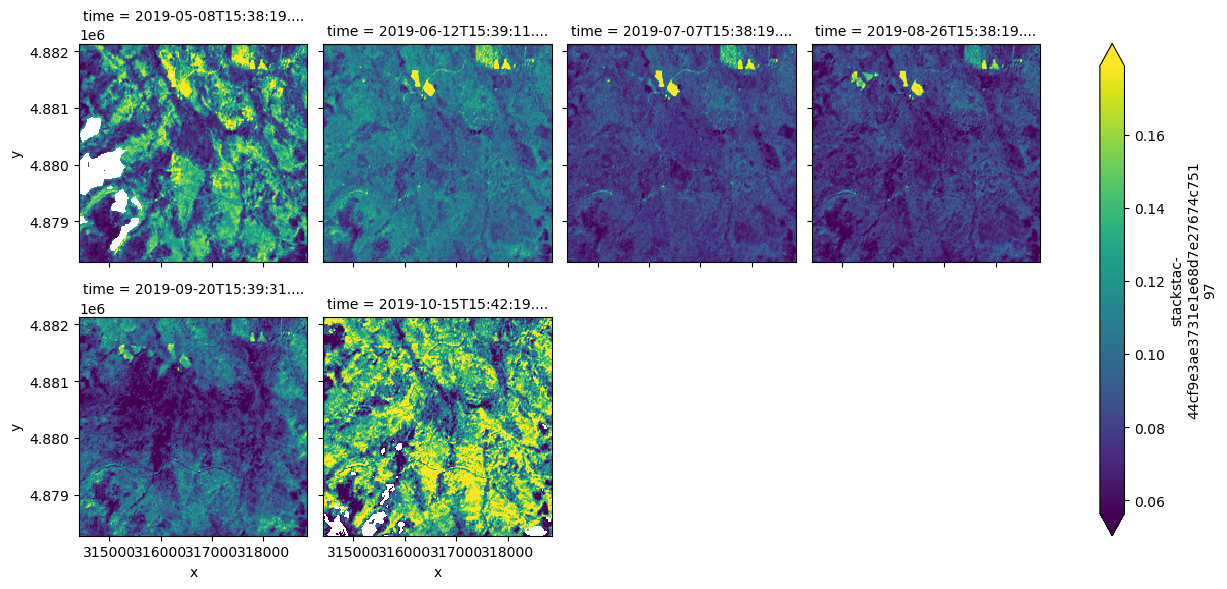

In [ ]:
# manually inspect input data and select the timestamps to keep
roi1.select_season_data(date_list=['05-08','06-12','07-07','08-26','09-20','10-15'])
roi1.plot_season_data(band=3)

In [ ]:
roi1.coregister_data()

In [8]:
roi1.add_all_variables(num_months=6,num_of_peak_evi_month=2)

variables saved to c:\Users\roseh\OneDrive - Hunter - CUNY\Documents\beech_tree/sentinel_data/bartlett/2019_bart_variables.nc


In [9]:
roi1.get_season_differences('month2','month5','summerminusfall_nonmasked')

diffs saved to c:\Users\roseh\OneDrive - Hunter - CUNY\Documents\beech_tree/sentinel_data/bartlett/2019_bart_diffs_summerminusfall_nonmasked.nc


In [ ]:
gs_months=['month1','month2','month3']
ssf_months=['month0','month2','month5']

tc_bands = ['B','evi','bright','green','wet']
nontc_bands = ['B','evi','lswi','slavi','psri']



p1, p2 = roi1.run_pca(n=15,monthstouse=gs_months,bandstouse=tc_bands,diff_desc='summerminusfall',output_desc='gs_tc',save=True)

explained variance: [0.60511863 0.79735553 0.8480642  0.8904002  0.916802   0.9403233
 0.9509751  0.95836663 0.96463484 0.96983236 0.97449994 0.9779058
 0.981031   0.983791   0.9861946 ]
pca saved to c:\Users\roseh\OneDrive - Hunter - CUNY\Documents\beech_tree/sentinel_data/bartlett/2019_bart_pca_gs_tc.nc


In [ ]:
r = roi1.endmember_manual.get_coordinates()

v = []
for i in range(r.shape[0]):
    value = m1.mnf_image.sel(x=r.iloc[i,0], y=r.iloc[i,1], method="nearest").values
    v.append(value)

v_mean = np.mean(v,axis=0)

In [45]:
v_mean = np.mean(v,axis=0)

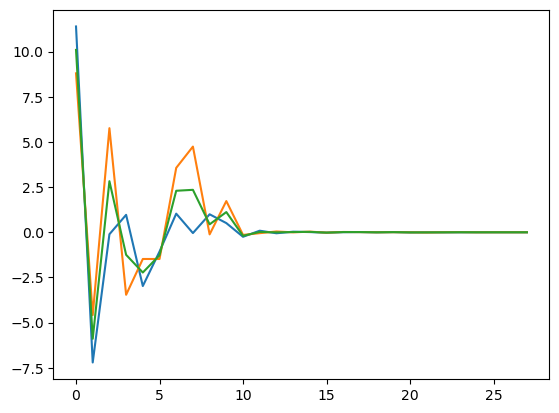

In [46]:
plt.plot(np.arange(28),v[0])
plt.plot(np.arange(28),v[1])
plt.plot(np.arange(28),v_mean)

### Minimum Noise Fraction

In [47]:
class MNF():
    def __init__(self,mnf_image,noise_bbox,noise_cov_matrix,reg_noise_cov_matrix,whitening_matrix,em_array,em_mean,basal_area):
        self.mnf_image = mnf_image

        self.noise_bbox = noise_bbox
        self.noise_cov_matrix = noise_cov_matrix
        self.reg_noise_cov_matrix = reg_noise_cov_matrix
        self.whitening_matrix = whitening_matrix
        self.em_array = em_array
        self.em_mean = em_mean
        self.basal_area = basal_area
    
    def plot_noise_region(self):
        bx, by = self.noise_bbox.exterior.xy

        plt.imshow(self.mnf_image[0,:,:])
        plt.fill(bx,by,edgecolor='red',facecolor='red',alpha=0.4)
    
    def check_noise_cov_matrix(self):
        # check stability of noise covariance matrix
        determinant = np.linalg.det(self.noise_cov_matrix) # should be greater than 10e-10
        condition = np.linalg.cond(self.noise_cov_matrix) # should be below 10e7

        eigvals = np.linalg.eigvals(self.noise_cov_matrix)

        print(f'original matrix\ndeterminant: {determinant}\ncondition: {condition}\neigen mean: {np.mean(eigvals)}\neigen variance: {np.var(eigvals)}')

        determinant = np.linalg.det(self.reg_noise_cov_matrix) # should be greater than 10e-10
        condition = np.linalg.cond(self.reg_noise_cov_matrix) # should be below 10e7

        eigvals = np.linalg.eigvals(self.reg_noise_cov_matrix)

        print(f'regularized matrix\ndeterminant: {determinant}\ncondition: {condition}\neigen mean: {np.mean(eigvals)}\neigen variance: {np.var(eigvals)}')

    def check_noise_whitening(self):
        whitened_noise_cov = self.whitening_matrix @ self.reg_noise_cov_matrix @ self.whitening_matrix.T

        plt.imshow(whitened_noise_cov)  # if resembles identity matrix, whitening is applied correctly
    
    def plot_mnf_variance(self):
        # plt.figure(figsize=(12, 6))
        # for i in range(10):  
        #     plt.subplot(2, 5, i + 1)
        #     plt.imshow(self.mnf_image[i,:, :])
        #     plt.title(f"MNF Band {i+1}")
        # plt.show()

        variance = [np.nanvar(self.mnf_image[i,:,:])for i in range(10)]

        plt.plot(np.arange(0,len(variance)),variance)
        plt.show()
        
        
# get noise region based on variance
def get_noise_region_variance(data,percentile):
    
    image = data[0:3,:,:]
    #image = data
    #apply window, calculate variance
    variance_map = np.mean([generic_filter(image[b,:, :], lambda x: np.var(x), size=13) for b in range(image.shape[0])], axis=0)
    # find areas with variance < percentile
    x_2d = rearrange(variance_map,'h w -> (h w)')
    varmap_dropna = x_2d[~np.isnan(x_2d)]   
    threshold = np.percentile(varmap_dropna, percentile)
    low_var = variance_map < threshold
    #extract largest region of low variance
    binary_mask = low_var.astype(np.uint8)

    # Find contours of homogeneous regions
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # Get the largest region
    largest_contour = max(contours, key=cv2.contourArea)
    # Get bounding box coordinates
    x, y, w, h = cv2.boundingRect(largest_contour)

     #box(xmin, ymin, xmax, ymax,
    bx = box(x,y+h,x+w,y)
    
    # Extract the subregion from the image
    return data[:,y:y+h, x:x+w], bx

# get noise region based on otsu thresholding
def get_noise_region_otsu(data): 
    data_array = data.values
    image_rearrange = rearrange(data_array,'c h w -> h w c' )
    image = image_rearrange[:,:,0:3]
    im = np.ma.masked_invalid(image)

    im_norm = im / np.max(im) # normalize the data to 0 - 1
    im_scale = 255 * im_norm # scale by 255
    im_u8 = im_scale.astype(np.uint8) # convert to uint 8
    img = cv2.cvtColor(im_u8, cv2.COLOR_BGR2GRAY) 
    # applying Otsu thresholding 
    # as an extra flag in binary  
    # thresholding      
    ret, low_var = cv2.threshold(img, 120, 255, cv2.THRESH_BINARY + 
                                                cv2.THRESH_OTSU) 

    # extract largest region of low variance
    binary_mask = low_var.astype(np.uint8)

    # Find contours of homogeneous regions
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # Get the largest region
    largest_contour = max(contours, key=cv2.contourArea)
    # Get bounding box coordinates
    x, y, w, h = cv2.boundingRect(largest_contour)

     #box(xmin, ymin, xmax, ymax,
    bx = box(x,y+h,x+w,y)
    
    # Extract the subregion from the image
    return data[:,y:y+h, x:x+w], bx

def estimate_noise(image):
    noise = np.zeros_like(image)
    
    # Compute noise for each band
    for b in range(image.shape[0]):
        x_ij = image[b,:, :]
        x_ip1_j = np.roll(x_ij, shift=-1, axis=0)  # Shift left (i+1, j)
        x_i_jp1 = np.roll(x_ij, shift=-1, axis=1)  # Shift up (i, j+1)
        
        # Compute noise 
        noise[b, :, :] = x_ij - 0.5 * (x_ip1_j + x_i_jp1)
    
    return noise

def estimate_noise_gaussian(img):
  
    # Generate Gaussian noise with mean=0, std=0.012 (same shape as image)
    rnoisy = np.random.normal(0, 0.012, size=img.shape)

    # Compute per-channel RMS (Root Mean Square) value
    rms = np.sqrt(np.nanmean(img ** 2, axis=(1, 2), keepdims=True))

    # Scale noise by image RMS 
    noise = rms * rnoisy

    return noise

def get_noise_cov_matrix(noise_matrix):
    
    noise = rearrange(noise_matrix, 'c h w -> (h w) c')

    # remove nans
    noise = noise[~np.isnan(noise).any(axis=1)]  # Remove rows with NaNs
   
    cov = np.cov(noise,rowvar=False)
    
    return cov

def check_matrix(n_cov_matrix):
# check stability of noise covariance matrix
    determinant = np.linalg.det(n_cov_matrix) # should be greater than 10e-10
    condition = np.linalg.cond(n_cov_matrix) # should be below 10e7

    eigvals = np.linalg.eigvals(n_cov_matrix)

    # data_variance = np.nanvar(data, axis=(1,2))  # Variance across spatial dimensions
    # mean_data_variance = np.mean(data_variance)
    # mean_data_variance

    print(f'determinant: {determinant}\ncondition: {condition}\neigen min: {np.min(eigvals)}\neigen max: {np.max(eigvals)}\neigen mean: {np.mean(eigvals)}\neigen variance: {np.var(eigvals)}\neigvals: {eigvals}')

####### adding regularization term gives more numerically resonable output ###########
def regularize_noise(noise_cov_matrix):
    lambda_reg = 1e-1 * np.eye(noise_cov_matrix.shape[0])  # diagonal offset
    reg_cov_matrix = noise_cov_matrix + lambda_reg 

    return reg_cov_matrix


def get_ba_threshold(basal_area):
    r = basal_area.values
    r = r[~np.isnan(r)]

    return round(np.percentile(r,99),3)

def get_endmembers(ba,mnf):  # return pixels with > 99th percentile of basal area
    thresh = get_ba_threshold(ba)
    h = ba
    rows, cols = np.where(h>=thresh)
    pixels = [(int(row),int(col)) for row,col in zip(rows,cols)]
    print(f'found {len(pixels)} pixels where beech is {thresh} percent or higher basal area')
  

    p_list = []

    for i in range(0,len(pixels)):
        p_list.append(mnf.values[:,pixels[i][0],pixels[i][1]])

    p_array = np.array(p_list) 
    

    p_mean = np.nanmean(p_array,axis=0)

    return p_array, p_mean

def get_endmembers_manual(em, mnf):
    r = em.get_coordinates()

    v = []
    for i in range(r.shape[0]):
        value = mnf.sel(x=r.iloc[i,0], y=r.iloc[i,1], method="nearest").values
        v.append(value)

    v_mean = np.mean(v,axis=0)

    return v, v_mean
    
def create_mnf_image(datastack,n1,n2,reg=True,em_manual=True):
    # takes in DataStack object
    # outputs MNF object with:
        # noise region bbox
        # noise covariance matrix
        # mnf image
        # endmembers in mnf space
    data = datastack.mnf_input.values[n1:n2,:,:]
    

    noise_region, noise_bbox = get_noise_region_variance(data, 30) # first three bands only

    noise = estimate_noise_gaussian(noise_region)
    ############ step 1: whiten data ###########
    n_cov_matrix = get_noise_cov_matrix(noise)
    if reg == True:
        reg_n_cov_matrix = regularize_noise(n_cov_matrix)
        eigvals, eigvecs = np.linalg.eigh(reg_n_cov_matrix)
    else:
        eigvals, eigvecs = np.linalg.eigh(n_cov_matrix)
        reg_n_cov_matrix = None


    # mean correct and reshape the data 
    m = np.nanmean(data, axis=0)
    data = data - m
    reshaped_data = rearrange(data,'b h w -> b (h w)') 

    # Compute the whitening matrix 
    inv_sqrt_eigenvalues = np.diag(1.0 / np.sqrt(eigvals))  # Compute R = Λ^(-1/2)
    whitening_matrix = eigvecs @ inv_sqrt_eigenvalues @ eigvecs.T  \
    # apply whitening transform
    whitened_data = whitening_matrix @ reshaped_data

    ####### step 2: PCA rotation #######
    # drop nas before applying pca
    whitened_data = rearrange(whitened_data,'c r -> r c')
    dropna = whitened_data[~np.isnan(whitened_data).any(axis=1)]
    # get indices of dropped nas to replace them later
    na_indices = np.where(np.isnan(whitened_data))
    row_indices = np.unique(na_indices[0]) # indices of rows that were dropped 

    # pca on whitened data; needs to be in form (rows, columns)
    pca = PCA()
    mnf = pca.fit_transform(dropna)

    # replace nans that were dropped earlier
    output_array = np.full((whitened_data.shape[0],mnf.shape[1]), np.nan)  # create array of correct shape
    non_nan_indices = np.setdiff1d(np.arange(whitened_data.shape[0]), row_indices) 
    output_array[non_nan_indices] = mnf

    # Reshape back to image format
    mnf_image = rearrange(output_array,'(h w) b -> b h w',h=data.shape[1],w=data.shape[2])


    # convert to xarray with geographic coodinates
    band_names = [f'comp_{x}' for x in range(mnf_image.shape[0])]
    mnf_image = xr.DataArray(mnf_image, coords={'band': band_names,'y': datastack.y_coords, 'x': datastack.x_coords},dims=['band','y','x'])
    
    ########### get endmembers ###############
    if em_manual == True:
        endmember_array, endmember_mean = get_endmembers_manual(datastack.endmember_manual, mnf=mnf_image)
    else:
        endmember_array, endmember_mean = get_endmembers(datastack.basal_area, mnf_image)

    return MNF(mnf_image = mnf_image,noise_bbox=noise_bbox, noise_cov_matrix=n_cov_matrix, reg_noise_cov_matrix=reg_n_cov_matrix,whitening_matrix=whitening_matrix,em_array=endmember_array,em_mean=endmember_mean,basal_area=datastack.basal_area)





# get cov matrix of mnf, find how many eigenvalues are > threshold, select that number of components from mnf image
def get_num_high_signal_components(mnf_image,thresh):
    mnf_2d = rearrange(mnf_image, 'c h w -> (h w) c')
    mnf_dropna = mnf_2d[~np.isnan(mnf_2d).any(axis=1)]  # Remove rows with NaNs
    mnf_cov = np.cov(mnf_dropna,rowvar=False)
    mnf_eigvals, _ = np.linalg.eigh(mnf_cov)
    return len(mnf_eigvals[mnf_eigvals>=thresh]), mnf_eigvals

def make_2d_input_data(data):
    x_2d = rearrange(data,'c h w -> (h w) c')
    x_dropna = x_2d[~np.isnan(x_2d).any(axis=1)]  # Remove rows with NaNs
    
    # get indices of dropped nas to replace them later
    na_indices = np.where(np.isnan(x_2d))
    row_indices = np.unique(na_indices[0]) # indices of rows that were dropped from a_2d

    return x_2d, x_dropna, row_indices

def replace_na_and_reshape(data_2d,final_data,indices,shape):
# replace nans that were dropped earlier
    output = np.full((data_2d.shape[0]), np.nan)  # create array of correct shape

    # Fill in the rows that were not NaN
    non_nan_indices = np.setdiff1d(np.arange(data_2d.shape[0]), indices)  # get indices that don't have na values
    output[non_nan_indices] = final_data

    r = output.reshape((shape[1],shape[2]) + (-1,)).squeeze()
    return r
    


def mixture_tuned_matched_filter(mnf_object,SNR,mean=True):
    # takes in MNF object
    # outputs array with MF score, IF score, and basal area bands

    ###### select MNF components to use###########
    t = SNR # threshold for eigenvalues
    n, eigvals = get_num_high_signal_components(mnf_object.mnf_image.values,t)
    mnf = mnf_object.mnf_image.values[:n,:,:]
    print(f'{n} MNF components used with eigvals between {np.min(eigvals[eigvals>=t])} and {np.max(eigvals[eigvals>=t])}')

    # Target spectral signature 
    if mean == True:
        target = mnf_object.em_mean[:n]
    else:
        target = mnf_object.em_array[0][:n]
    # background mean 
    #u_b = np.nanmean(mnf, axis=(1, 2))  
    # difference between target and background mean - not present in Mundt
    #d_tb = (target- u_b)
    ############ matched filter ######################
    # Calculate the covariance matrix of the background
    mnf_2d, mnf_dropna, na_indices = make_2d_input_data(mnf) 
    C = np.cov(mnf_dropna, rowvar=False)  

    det = np.linalg.det(C) # should be greater than 10e-10
    cond = np.linalg.cond(C) # should be below 10e7
    print(f'mnf covariance matrix:\n  determinant: {det}\n  condition: {cond}')
    C1 = np.linalg.inv(C)
    #epsilon = 1e-6  # Small regularization term
    #C1 = np.linalg.inv(C + epsilon * np.eye(C.shape[0]))

    # Normalization coefficient 
    coef = 1.0 / target @ C1 @ target
    
    A = (coef * target) @ C1 # transformation matrix
    Y = (A @ mnf_dropna.T).T

    matched_filter = replace_na_and_reshape(mnf_2d,Y,na_indices,mnf.shape)

    print(f'MF max: {np.nanmax(matched_filter)}, MF min: {np.nanmin(matched_filter)}, MF mean: {np.nanmean(matched_filter)}')

    

    ######## infeasibility score #################

    # Compute target vector component 
    target_component = matched_filter[..., np.newaxis] * target  # Shape: (H, W, D)
    target_component = rearrange(target_component,'h w d -> d h w')

    eigvals, _ = np.linalg.eigh(C) # C = covariance matrix of mnf image
    # Compute interpolated eigenvalues; scale mnf eigenvalues based on the MF scores
    noise = np.ones((n,))  # size corresponds to number of components; noise has unit variance

    sqrt_eig = np.sqrt(eigvals)  
    interp_eig = (sqrt_eig - matched_filter[..., np.newaxis] * (sqrt_eig - noise))**2  

    interp_eig = np.where(interp_eig == 0, 1e-6, interp_eig)  # Avoid divide-by-zero issues
    interp_eig = rearrange(interp_eig,'h w d -> d h w')

    r = mnf - target_component
    r_2d, r_dropna, r_indices = make_2d_input_data(r)

    r_norm = np.linalg.norm(np.nan_to_num(r_dropna),axis=1)
    r2 = replace_na_and_reshape(r_2d,r_norm,r_indices,mnf.shape)

    e_2d, e_dropna, e_indices = make_2d_input_data(interp_eig)

    s = np.linalg.norm(np.nan_to_num(e_dropna,nan=1e-6),axis=1)
    s2 = replace_na_and_reshape(e_2d,s,e_indices,mnf.shape)

    infeas_score = r2/s2

    print(f'infeas max: {np.nanmax(infeas_score)}, infeas min: {np.nanmin(infeas_score)}, infeas mean: {np.nanmean(infeas_score)}')

    matched_filter = xr.DataArray(matched_filter, coords={'y': mnf_object.mnf_image.y.values, 'x': mnf_object.mnf_image.x.values},dims=['y','x'])

    infeas_score = xr.DataArray(infeas_score, coords={'y': mnf_object.mnf_image.y.values, 'x': mnf_object.mnf_image.x.values},dims=['y','x'])

    q = xr.concat([matched_filter,infeas_score,mnf_object.basal_area],dim='band')
    q = q.assign_coords({'band':['mf_score','infeas_score','basal_area']})
    
    return MTMF(array=q,target=target)



class MTMF():
    def __init__(self,array,target):
        self.result_array = array
        self.target = target
        self.matched_filter = self.result_array.sel(band='mf_score').values
        self.infeas_score = self.result_array.sel(band='infeas_score').values
        self.basal_area = self.result_array.sel(band='basal_area').values


    def plot_histograms(self):
        fig, ax = plt.subplots(1, 2, figsize=(8,4))

        ax[0].hist(self.matched_filter.flatten(), bins=50)
        ax[0].set_title("Matched Filter")

        ax[1].hist(self.infeas_score.flatten(), bins=50)
        ax[1].set_title("Infeasibility")

        plt.tight_layout()
        plt.show()

    def plot_correlation(self,n):
        
        i_2d = rearrange(self.infeas_score,'h w -> (h w)')
        ba_2d = rearrange(self.basal_area,'h w -> (h w)')
        t2_2d = rearrange(self.matched_filter,'h w -> (h w)')

        combine = np.vstack((ba_2d,t2_2d,i_2d)).T

        combine = combine[~np.isnan(combine).any(axis=1)]

        df = pd.DataFrame(combine)
        df.columns = ['basal_area','mf_score','infeas_score']
        df.loc[df['basal_area']<n,'basal_binary'] = 0
        df.loc[df['basal_area'] >= n, 'basal_binary'] = 1

        sns.scatterplot(data=df, x='mf_score', y='infeas_score', hue='basal_binary',palette=['turquoise', 'crimson'])

        # sns.scatterplot(data=df, x='mf_score', y='infeas_score', hue='basal_area',palette=sns.color_palette("rocket", as_cmap=True))

        
        

    
    


    

In [24]:
# output = MnfInput object (stack of bands to use to calculate mnf)
# months = which months bands to include
# v1, v2 = which version of pca to use
# diff_desc = which difference to use (e.g. 'summerminusfall')

#gs_tc_mnf_input = roi1.make_mnf_input(v1='gs',v2='tc',month='month2',diffs=True,diff_num=0)
roi1.make_mnf_input(v1='gs',v2='tc',month=['month5'],diff_desc='summerminusfall')
#ssf_tc_mnf_input = roi1.make_mnf_input(v1='ssf',v2='tc',month='month2',diffs=True,diff_num=0)

In [48]:
m1 = create_mnf_image(roi1,n1=0,n2=28,reg=True,em_manual=True)

C:\Users\roseh\AppData\Local\Temp\ipykernel_15520\2764980198.py:236: RuntimeWarning: Mean of empty slice
  m = np.nanmean(data, axis=0)


In [ ]:
m1.plot_mnf_variance()

In [98]:
m2 = mixture_tuned_matched_filter(m1,SNR=19,mean=True)

3 MNF components used with eigvals between 22.068760659556673 and 252.94695723411886
mnf covariance matrix:
  determinant: 464012.024978854
  condition: 11.46176539481306
MF max: 0.5165235934613476, MF min: -0.8273352053354595, MF mean: -7.609397653424611e-17
infeas max: 1.3471462662414126, infeas min: 0.00042614803995852336, infeas mean: 0.057479151002510616


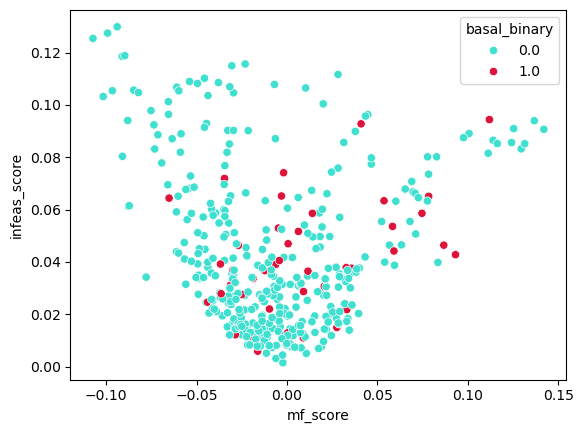

In [100]:
m2.plot_correlation(n=100) ### include 0% basal area pixels

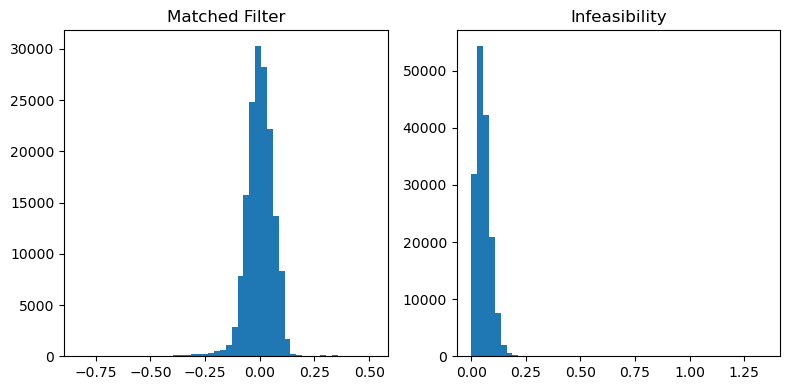

In [101]:
m2.plot_histograms()

In [93]:
mask_1 = m2.result_array.sel(band='mf_score')>0
mask_2 = m2.result_array.sel(band='infeas_score')<0.05

threshold = m2.result_array.where(mask_1 & mask_2)

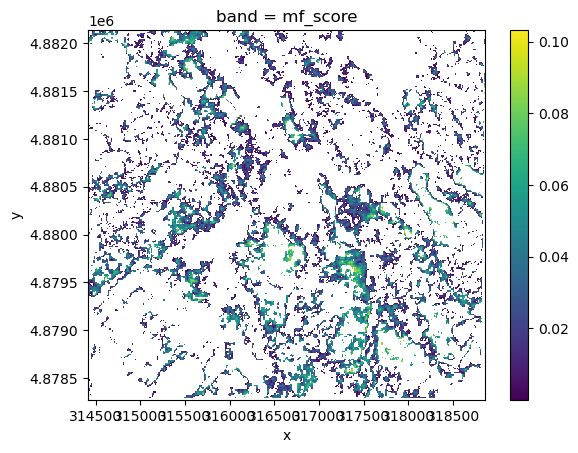

In [94]:
threshold.sel(band='mf_score').plot() ## manual endmember got different spatial distribution

In [159]:
# whiten data 
eigvals, eigvecs = np.linalg.eigh(n_cov_matrix)

# clamp eigenvalues to prevent ill-conditioned noise cov matrix
# condition_limit = 1e6  
# lambda_max = np.max(eigvals)
# threshold = lambda_max / condition_limit
# eigvals = np.maximum(eigvals, threshold)

# set relative threshold
# alpha = 1e-5
# lambda_max = np.max(eigvals)
# threshold = alpha * lambda_max  
# eigvals = np.maximum(eigvals, threshold) 

# mean correct and reshape the data 
m = np.nanmean(data, axis=0)
data = data - m
reshaped_data = rearrange(data,'b h w -> b (h w)') 

###########################
# Compute the whitening matrix (Mahalanobis whitening)
#whitening_matrix = np.dot(np.linalg.inv(np.sqrt(np.diag(eigvals))), eigvecs.T)
#Apply whitening transform
#whitened_data = np.dot(reshaped_data, whitening_matrix.T)
######## gee ###############################
inv_sqrt_eigenvalues = np.diag(1.0 / np.sqrt(eigvals))  # Compute R = Λ^(-1/2)
whitening_matrix = eigvecs @ inv_sqrt_eigenvalues @ eigvecs.T  # Compute whitening transformation
whitened_image = whitening_matrix @ reshaped_data

C:\Users\roseh\AppData\Local\Temp\ipykernel_15216\3835613364.py:17: RuntimeWarning: Mean of empty slice
  m = np.nanmean(data, axis=0)


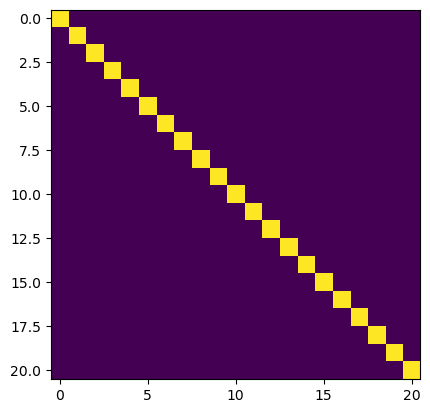

In [160]:
# check noise whitening
whitened_noise_cov = whitening_matrix @ n_cov_matrix @ whitening_matrix.T
plt.imshow(whitened_noise_cov)  # if resembles identity matrix, whitening is applied correctly

In [161]:
# get indices of dropped nas to replace them later
whitened_data = rearrange(whitened_image,'c r -> r c')
dropna = whitened_data[~np.isnan(whitened_data).any(axis=1)]

# get indices of dropped nas to replace them later
na_indices = np.where(np.isnan(whitened_data))
row_indices = np.unique(na_indices[0]) # indices of rows that were dropped 

# pca on whitened data; needs to be in form (rows, columns)
pca = PCA()
mnf = pca.fit_transform(dropna)

# replace nans that were dropped earlier
output_array = np.full((whitened_data.shape[0],mnf.shape[1]), np.nan)  # create array of correct shape

non_nan_indices = np.setdiff1d(np.arange(whitened_data.shape[0]), row_indices) 
output_array[non_nan_indices] = mnf

# Reshape back to image format
mnf_components = rearrange(output_array,'(h w) b -> b h w',h=data.shape[1],w=data.shape[2])

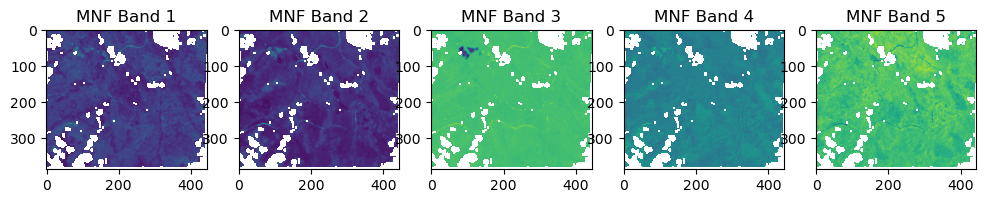

In [162]:
#mnf_components = mnf_components_alldata
plt.figure(figsize=(12, 6))
for i in range(5):  
    plt.subplot(1, 5, i + 1)
    plt.imshow(mnf_components[i,:, :])
    plt.title(f"MNF Band {i+1}")
plt.show()

In [163]:
[np.nanvar(mnf_components[i,:,:])for i in range(15)] 

[np.float64(97.07491184224699),
 np.float64(30.107140396728756),
 np.float64(16.62828168285952),
 np.float64(13.114517897588792),
 np.float64(9.229450299218712),
 np.float64(0.012328256421475139),
 np.float64(0.002813136430032592),
 np.float64(0.0016590312825330454),
 np.float64(0.0011260152525309824),
 np.float64(0.0008758004897758289),
 np.float64(0.00036854222247572157),
 np.float64(0.0003013665982982625),
 np.float64(0.0002630502851509608),
 np.float64(0.0001389434460488295),
 np.float64(7.221985309577555e-05)]

In [ ]:
t = mnf_components[0:2,:,:]
t = rearrange(t,'c h w -> c (h w)')

fig,ax = plt.subplots()

plt.scatter(t[0,:],t[1,:])

In [165]:
def get_ba_threshold(basal_area):
    r = basal_area.values
    r = r[~np.isnan(r)]

    return round(np.percentile(r,99),3)

def get_endmembers(ba,mnf):  # return pixels with > 99th percentile of basal area
    thresh = get_ba_threshold(ba)
    h = ba
    rows, cols = np.where(h>=thresh)
    pixels = [(int(row),int(col)) for row,col in zip(rows,cols)]
    print(f'found {len(pixels)} beech pixels with greater than {thresh} basal area')
  

    p_list = []

    for i in range(0,len(pixels)):
        p_list.append(mnf[:,pixels[i][0],pixels[i][1]])

    p_array = np.array(p_list) 
    

    p_mean = np.mean(p_array,axis=0)

    return p_array, p_mean

em_spectra, em_mean = get_endmembers(roi1.basal_area,mnf_components)
   

found 5 beech pixels with greater than 0.003 basal area


In [166]:
# get cov matrix of mnf, find how many eigenvalues are > threshold, select that number of components from mnf image
def get_num_high_signal_components(mnf_image,thresh):
    mnf_2d = rearrange(mnf_image, 'c h w -> (h w) c')
    mnf_dropna = mnf_2d[~np.isnan(mnf_2d).any(axis=1)]  # Remove rows with NaNs
    mnf_cov = np.cov(mnf_dropna,rowvar=False)
    mnf_eigvals, _ = np.linalg.eigh(mnf_cov)
    return len(mnf_eigvals[mnf_eigvals>=thresh]), mnf_eigvals

def make_2d_input_data(data):
    x_2d = rearrange(data,'c h w -> (h w) c')
    x_dropna = x_2d[~np.isnan(x_2d).any(axis=1)]  # Remove rows with NaNs
    
    # get indices of dropped nas to replace them later
    na_indices = np.where(np.isnan(x_2d))
    row_indices = np.unique(na_indices[0]) # indices of rows that were dropped from a_2d

    return x_2d, x_dropna, row_indices

def replace_na_and_reshape(data_2d,final_data,indices):
# replace nans that were dropped earlier
    output = np.full((data_2d.shape[0]), np.nan)  # create array of correct shape

    # Fill in the rows that were not NaN
    non_nan_indices = np.setdiff1d(np.arange(data_2d.shape[0]), indices)  # get indices that don't have na values
    output[non_nan_indices] = final_data

    shape= mnf_components.shape
    r = output.reshape((shape[1],shape[2]) + (-1,)).squeeze()
    return r
    # create data array with geographic coordinates
    #return xr.DataArray(r, coords={'y': self.y_coords, 'x': self.x_coords},dims=['y','x'])


###### apply matched filter algorithm ###########
t = 5 # threshold for eigenvalues
n, eigvals = get_num_high_signal_components(mnf_components,t)
mnf = mnf_components[:n,:,:]
print(f'{n} MNF components used with eigvals between {np.min(eigvals[eigvals>=t])} and {np.max(eigvals[eigvals>=t])}')

# Target spectral signature 
target = em_mean[:n]
# background mean 
u_b = np.nanmean(mnf, axis=(1, 2))  
# difference between target and background mean - not present in Mundt
#target = (target- u_b)
# Calculate the covariance matrix of the background
mnf_2d, mnf_dropna, na_indices = make_2d_input_data(mnf) 
C = np.cov(mnf_dropna, rowvar=False)  

det = np.linalg.det(C) # should be greater than 10e-10
cond = np.linalg.cond(C) # should be below 10e7
print(f'mnf covariance matrix:\n  determinant: {det}\n  condition: {cond}')
C1 = np.linalg.pinv(C)
#epsilon = 1e-6  # Small regularization term
#C1 = np.linalg.inv(C + epsilon * np.eye(C.shape[0]))

# Normalization coefficient 
#coef = 1.0 / d_tb @ C1 @ d_tb
coef = 1.0 / target @ C1 @ target
# 2d array input
X = mnf_dropna
#A = (coef * d_tb) @ C1 #transform method
A = (coef * target) @ C1 
Y = (A @ X.T).T

matched_filter = replace_na_and_reshape(mnf_2d,Y,na_indices)

print(f'MF max: {np.nanmax(matched_filter)}, MF min: {np.nanmin(matched_filter)}, MF mean: {np.nanmean(matched_filter)}')

5 MNF components used with eigvals between 9.229507848402179 and 97.07551714177525
mnf covariance matrix:
  determinant: 5882549.508701107
  condition: 10.51795163255436
MF max: 1.909627162813632, MF min: -2.793906453070234, MF mean: 6.025453438380657e-17


In [167]:
# infeasibility score

# Compute target vector component (MNF_t)
target_component = matched_filter[..., np.newaxis] * target  # Shape: (H, W, D)
target_component = rearrange(target_component,'h w d -> d h w')

eigvals, _ = np.linalg.eigh(C) # covariance matrix of mnf image
# Compute interpolated eigenvalues; scale mnf eigenvalues based on the MF scores
noise = np.ones((n,))  # size corresponds to number of components; noise has unit variance

sqrt_eig = np.sqrt(eigvals)  
interp_eig = (sqrt_eig - matched_filter[..., np.newaxis] * (sqrt_eig - noise))**2  

interp_eig = np.where(interp_eig == 0, 1e-6, interp_eig)  # Avoid divide-by-zero issues
interp_eig = rearrange(interp_eig,'h w d -> d h w')

r = mnf - target_component
r_2d, r_dropna, r_indices = make_2d_input_data(r)

r_norm = np.linalg.norm(np.nan_to_num(r_dropna),axis=1)
r2 = replace_na_and_reshape(r_2d,r_norm,r_indices)

e_2d, e_dropna, e_indices = make_2d_input_data(interp_eig)

s = np.linalg.norm(np.nan_to_num(e_dropna,nan=1e-6),axis=1)
s2 = replace_na_and_reshape(e_2d,s,e_indices)

infeas_score = r2/s2


In [ ]:
class MTMF():
    # code based on spectral package
    # y={(mu_t-mu_b)^TSigma^{-1}(x-mu_b)}/{(mu_t-mu_b)^TSigma^{-1}(mu_t-mu_b)}
    def __init__(self,mnf_object):
        self.target_spectra = mnf_object.endmember_spectra # array of spectra
        self.mean_target = mnf_object.endmember_mean
        self.y_coords = mnf_object.y_coords
        self.x_coords = mnf_object.x_coords
        self.mnf = mnf_object.mnf
        self.mtmf = None

    def make_2d_input_data(self,x):
        x_2d = rearrange(x,'c h w -> (h w) c')
        x_dropna = x_2d[~np.isnan(x_2d).any(axis=1)]  # Remove rows with NaNs
        
        # get indices of dropped nas to replace them later
        na_indices = np.where(np.isnan(x_2d))
        row_indices = np.unique(na_indices[0]) # indices of rows that were dropped from a_2d

        return x_2d, x_dropna, row_indices

    def replace_na_and_reshape(self,data_2d,final_data,indices):
    # replace nans that were dropped earlier
        output = np.full((data_2d.shape[0]), np.nan)  # create array of correct shape

        # Fill in the rows that were not NaN
        non_nan_indices = np.setdiff1d(np.arange(data_2d.shape[0]), indices)  # get indices that don't have na values
        output[non_nan_indices] = final_data

        shape= self.mnf.shape
        r = output.reshape((shape[1],shape[2]) + (-1,)).squeeze()

        # create data array with geographic coordinates
        return xr.DataArray(r, coords={'y': self.y_coords, 'x': self.x_coords},dims=['y','x'])
    

    def run_mtmf(self,mean=True,spectrum_index=None):
        # Target spectral signature 
        if mean is True:
            target = self.mean_target 
        else:
            target = self.target_spectra[spectrum_index]
        # background mean 
        u_b = np.nanmean(self.mnf, axis=(1, 2))  
        # difference between target and background mean; ensures detection is based on contrast, not absolute values
        d_tb = (target- u_b)

        # Calculate the covariance matrix of the background
        # reshape mnf data from 3d to 2d
        mnf_2d, mnf_dropna, na_indices = self.make_2d_input_data(self.mnf) 
        # Covariance matrix
        C = np.cov(mnf_dropna, rowvar=False)  
        # inverse of the covariance matrix
        C1 = np.linalg.inv(C)

        # Normalization coefficient (scales based on background variability)
        coef = 1.0 / d_tb @ C1 @ d_tb

        # 2d array input
        X = mnf_dropna
        A = (C1 @ d_tb) * coef    #transform method 
        Y = (A @ X.T).T

        out = self.replace_na_and_reshape(data_2d=mnf_2d,final_data=Y,indices=na_indices)

        self.mtmf = out


In [65]:
m2.result_array.band.values

array(['mf_score', 'infeas_score', 'basal_area'], dtype='<U12')

In [ ]:
from sklearn.linear_model import LinearRegression


i_2d = rearrange(m2.result_array.sel(band='infeas_score').values,'h w -> (h w)')
ba_2d = rearrange(m2.result_array.sel(band='basal_area').values,'h w -> (h w)')
t2_2d = rearrange(m2.result_array.sel(band='mf_score').values,'h w -> (h w)')

combine = np.vstack((ba_2d,t2_2d,i_2d)).T

combine = combine[~np.isnan(combine).any(axis=1)]

df = pd.DataFrame(combine)
df.columns = ['basal_area','mf_score','infeas_score']




X = df[['mf_score','infeas_score']]
y = df[['basal_area']]

reg = LinearRegression().fit(X, y)
reg.score(X, y)

y_pred = reg.predict(X)  # should predict entire raster, not the 400 pixels with basal area



<Axes: xlabel='basal_area', ylabel='mf_score'>

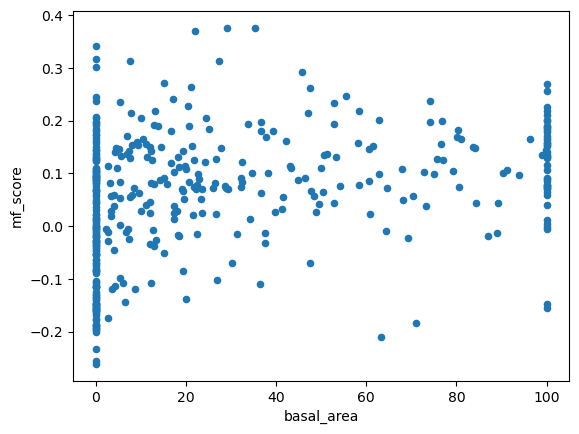

In [96]:
df.plot(y='mf_score',x='basal_area',kind='scatter')

0.11274980624547559

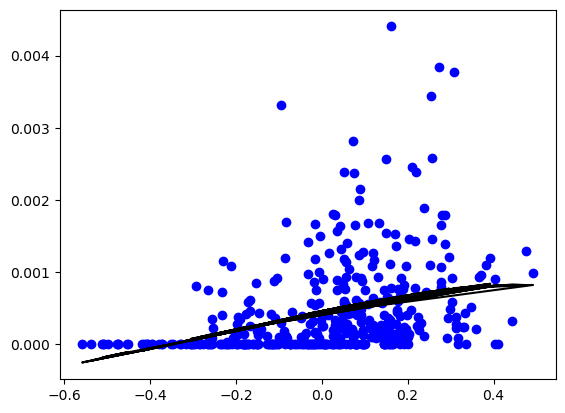

In [117]:
y_pred = reg.predict(X) 
plt.scatter(X[:,0], y, color ='b') 
plt.plot(X[:,0], y_pred, color ='k') 
  
plt.show()

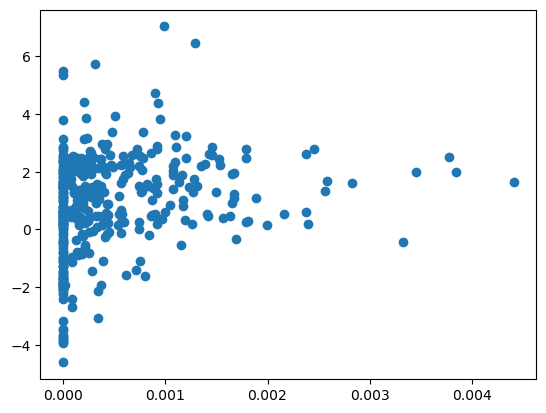

In [327]:
plt.scatter(df_mf[:,0],df_mf[:,1])

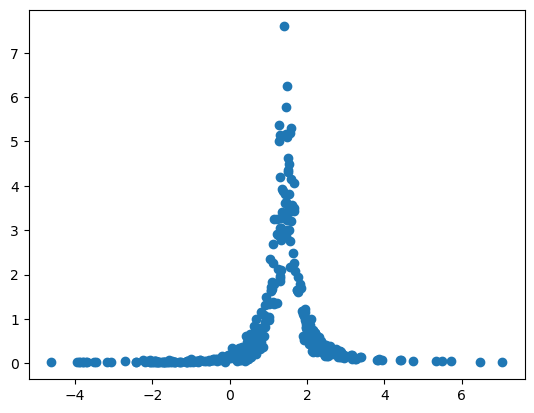

In [331]:
plt.scatter(df_mf[:,1],df_i[:,1])

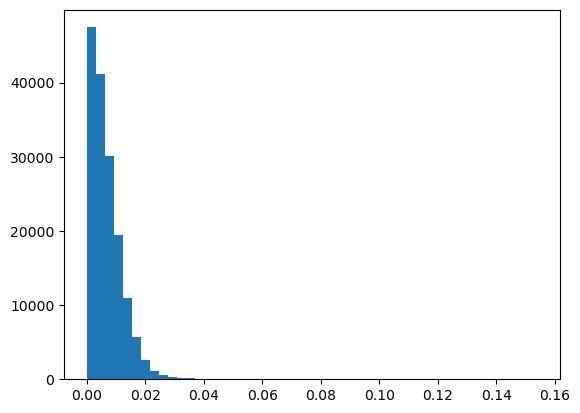

In [247]:
plt.hist(np.where(infeas_score<1,infeas_score,np.nan).flatten(),bins=50)
plt.show()

In [ ]:
class Endmembers():
    def __init__(self,epsg,mnf_data,beech_polygons):
        a = xr.DataArray(mnf_data, coords={'band':np.arange(0,w.mnf.shape[0]),'y': stack.all_variables.y,'x': stack.all_variables.x}, 
                    dims=['band','y','x'])
        self.epsg = epsg
        self.mnf = a.rio.write_crs(self.epsg).rio.set_spatial_dims(x_dim="x",y_dim="y",).rio.write_coordinate_system()
        self.polygons = beech_polygons.reset_index().to_crs(self.epsg)
        self.bbox = self.get_bbox()

        self.site_polygons = self.get_site_polygons() # polygons that intersect with bbox

        self.beech_idx = self.site_polygons.loc[self.site_polygons.Name!='non-beech stand']['index'].astype('float').values
        
        self.raster_polys = self.rasterize_polys()

        self.beech_pixel_coords= None
        self.target_spectra = None

    def get_bbox(self):
        b = self.mnf.rio.bounds()
        return box(*b)
    
    def get_site_polygons(self):
        df = gpd.GeoDataFrame({"id":1,"geometry":[self.bbox]})
        idx = df.sindex.query(self.polygons.geometry, predicate="intersects")[0]

        site_polys = self.polygons.iloc[idx]
        
        return site_polys.loc[site_polys.Name!='non-beech stand']
    
    # rasterize polygons
    def rasterize_polys(self):
        g = make_geocube(
        vector_data=self.site_polygons,
        measurements=["index"],
        like=self.mnf, # ensure the data are on the same grid
    )
        return g
    
    # plot rasterized polygons overlaid with vector polygons
    def plot_rasterized_polys(self):
        fig, ax = plt.subplots(ncols=1, figsize=(5, 5))

        p = self.raster_polys.index.plot.imshow(ax=ax)
        self.site_polygons.plot(ax=ax,alpha=.7)
        p.colorbar.remove()
        plt.title(f'Rasterized Beech Polygons')
        plt.tight_layout()
        plt.show()

    
    def get_beech_pixel_coords(self):
            
        h = self.raster_polys.index.values
        rows, cols = np.where(~np.isnan(h))

        pixels = [(int(row),int(col)) for row,col in zip(rows,cols)]
        print(f'found {len(pixels)} beech pixels')

        self.beech_pixel_coords = pixels
    
    def plot_beech_spectra(self,n):

        #h.shape = (y,x), mnf.shape = (b,y,x), y=rows(height), x=columns(width), 
        p_list = []

        for i in range(0,len(self.beech_pixel_coords)):
            p_list.append(self.mnf.values[:,self.beech_pixel_coords[i][0],self.beech_pixel_coords[i][1]])

        p_m = np.array(p_list[0:n]) 

        p_mean = np.mean(p_m,axis=0)

        fig,ax = plt.subplots(figsize=(5,5))

        for i in range(0,p_m.shape[0]):
            plt.plot(p_m[i])

        plt.plot(p_mean,color='black')

        plt.show()
       
       # to do: also return list of spectra so i can use it in MTMF class
        self.target_spectra = p_m